In [1]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score,KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, gcf
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
import tensorflow.keras.backend as K
from sklearn.metrics import recall_score,precision_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
df = pd.read_excel(r'C:\Users\amema\Desktop\مقاله\cad.xlsx')
df.head()

,Age,Weight,Length,Sex,BMI,DM,HTN,Current Smoker,EX-Smoker,FH,...,K,Na,WBC,Lymph,Neut,PLT,EF-TTE,Region RWMA,VHD,Cath
0,53,90,175,Male,29.387755,0,1,1,0,0,...,4.7,141,5700,39,52,261,50,0,N,Cad
1,67,70,157,Fmale,28.398718,0,1,0,0,0,...,4.7,156,7700,38,55,165,40,4,N,Cad
2,54,54,164,Male,20.077335,0,0,1,0,0,...,4.7,139,7400,38,60,230,40,2,mild,Cad
3,66,67,158,Fmale,26.838648,0,1,0,0,0,...,4.4,142,13000,18,72,742,55,0,Severe,Normal
4,50,87,153,Fmale,37.165193,0,1,0,0,0,...,4.0,140,9200,55,39,274,50,0,Severe,Normal


In [6]:
X = df.drop(['Cath'], axis=1)
Y = df['Cath']
X = pd.get_dummies(X)
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [7]:
skf = KFold(n_splits=20, shuffle=False, random_state=8)

In [23]:
XGB = XGBClassifier(n_estimators=200, objective='binary:logistic',learning_rate=1,
                    scale_pos_weight=9,max_depth=3,reg_alpha=0.01,reg_lambda=0.01,
                    seed=7)
pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]
    XGB.fit(Xtrain, Ytrain,verbose=1)
    p = XGB.predict_proba(Xtest)
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.85:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))
print('recall_score: ',recall_score(Y, pred_,pos_label=0))
print('F_Measure:   ', f1_score(Y, pred_,pos_label=0))
print('precision:   ',precision_score(Y, pred_,pos_label=0))
AUC = roc_auc_score(Y, pred)
print('AUC:         ', AUC)
print(confusion_matrix(Y, pred_))

[09:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:01:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

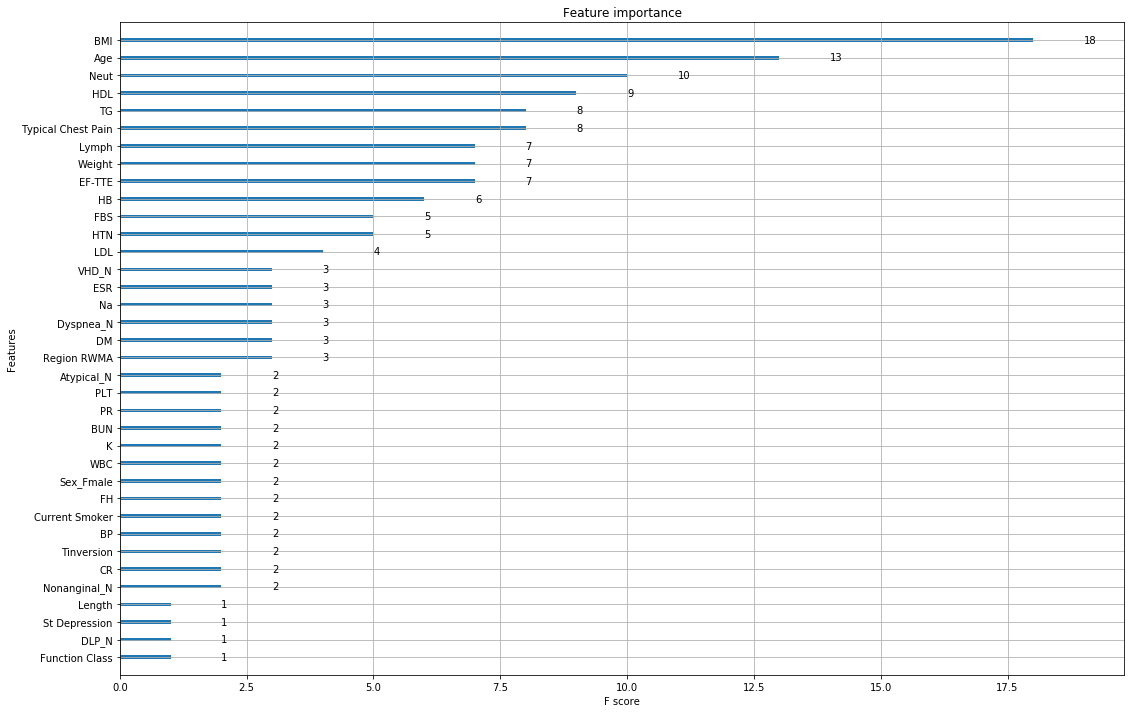

In [7]:
# feature importance
plt.rcParams["figure.figsize"] = (18,12)
plot_importance(XGB)
plt.show()

In [24]:
gbm = lgb.LGBMClassifier(n_estimators=200, silent=True, subsample=0.85, colsample_bytree=0.85, learning_rate=1)

pred = []
pred_ = []
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]
    gbm.fit(Xtrain, Ytrain, eval_set=[(Xtest, Ytest)], early_stopping_rounds=10, verbose=1)
    p = gbm.predict_proba(Xtest, num_iteration=gbm.best_iteration_)
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.5:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))
print('recall_score: ',recall_score(Y, pred_,pos_label=0))
print('F_Measure:   ', f1_score(Y, pred_,pos_label=0))
print('precision:   ',precision_score(Y, pred_,pos_label=0))
AUC = roc_auc_score(Y, pred)
print('AUC:         ', AUC)
print(confusion_matrix(Y, pred_))

[1]	valid_0's binary_logloss: 0.399871
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.326037
[3]	valid_0's binary_logloss: 0.331823
[4]	valid_0's binary_logloss: 0.289301
[5]	valid_0's binary_logloss: 0.254018
[6]	valid_0's binary_logloss: 0.181346
[7]	valid_0's binary_logloss: 0.232031
[8]	valid_0's binary_logloss: 0.12247
[9]	valid_0's binary_logloss: 0.21895
[10]	valid_0's binary_logloss: 0.182603
[11]	valid_0's binary_logloss: 0.195985
[12]	valid_0's binary_logloss: 0.193607
[13]	valid_0's binary_logloss: 0.198604
[14]	valid_0's binary_logloss: 0.168024
[15]	valid_0's binary_logloss: 0.203066
[16]	valid_0's binary_logloss: 0.158214
[17]	valid_0's binary_logloss: 0.191473
[18]	valid_0's binary_logloss: 0.141542
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.12247
[1]	valid_0's binary_logloss: 0.254729
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.441921
[3]	valid_0's bina

[2]	valid_0's binary_logloss: 0.306429
[3]	valid_0's binary_logloss: 0.328514
[4]	valid_0's binary_logloss: 0.251003
[5]	valid_0's binary_logloss: 0.264518
[6]	valid_0's binary_logloss: 0.30877
[7]	valid_0's binary_logloss: 0.366819
[8]	valid_0's binary_logloss: 0.41473
[9]	valid_0's binary_logloss: 0.414107
[10]	valid_0's binary_logloss: 0.364414
[11]	valid_0's binary_logloss: 0.3002
[12]	valid_0's binary_logloss: 0.356244
[13]	valid_0's binary_logloss: 0.383461
[14]	valid_0's binary_logloss: 0.362288
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.251003
[1]	valid_0's binary_logloss: 0.486657
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.610008
[3]	valid_0's binary_logloss: 0.345853
[4]	valid_0's binary_logloss: 0.340208
[5]	valid_0's binary_logloss: 0.369739
[6]	valid_0's binary_logloss: 0.309349
[7]	valid_0's binary_logloss: 0.247849
[8]	valid_0's binary_logloss: 0.227762
[9]	valid_0's binary_logloss: 0.288511
[10]	v

In [9]:
def create_baseline():
  model = Sequential()
  model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(25, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1)) 
  model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0)) 
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
#   op=optimizers.Adam(learning_rate=1)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
  return model

In [33]:
gbm = lgb.LGBMClassifier(n_estimators=200, silent=True, subsample=0.85, colsample_bytree=0.1, learning_rate=1)
XGB = XGBClassifier(n_estimators=200, objective='binary:logistic',learning_rate=1,
                    scale_pos_weight=9,max_depth=3,reg_alpha=0.1,reg_lambda=0.1,
                    seed=7)
model = KerasClassifier(build_fn=create_baseline)
p_lgb=[]
p_dnn=[]
p_xgb=[]
pred = []
pred_ = []

for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]
    gbm.fit(Xtrain, Ytrain, eval_set=[(Xtest, Ytest)], early_stopping_rounds=10, verbose=1)
    XGB.fit(Xtrain, Ytrain, eval_set=[(Xtest, Ytest)], early_stopping_rounds=10, verbose=1)
    model.fit(Xtrain,Ytrain, epochs=1000, batch_size=12, verbose=0, validation_data=(Xtest, Ytest))
    p = (gbm.predict_proba(Xtest, num_iteration=gbm.best_iteration_)*0.4+ XGB.predict_proba(Xtest)*0.2)+model.predict_proba(Xtest)*0.4
    p_lgb.append(gbm.predict_proba(Xtest, num_iteration=gbm.best_iteration_))
    p_dnn.append(model.predict_proba(Xtest))       
    p_xgb.append(XGB.predict_proba(Xtest))
    for pp in p:
        pred.append(pp[1])
        if pp[1]>0.58:
          pred_.append(1)
        else:
          pred_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_))
print('recall_score: ',recall_score(Y, pred_,pos_label=0))
print('F_Measure:   ', f1_score(Y, pred_,pos_label=0))
print('precision:   ',precision_score(Y, pred_,pos_label=0))
AUC = roc_auc_score(Y, pred)
print('AUC:         ', AUC)
print(confusion_matrix(Y, pred_))

[1]	valid_0's binary_logloss: 0.527771
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.570249
[3]	valid_0's binary_logloss: 0.714681
[4]	valid_0's binary_logloss: 0.710522
[5]	valid_0's binary_logloss: 0.427531
[6]	valid_0's binary_logloss: 0.570837
[7]	valid_0's binary_logloss: 0.694367
[8]	valid_0's binary_logloss: 0.685866
[9]	valid_0's binary_logloss: 0.691359
[10]	valid_0's binary_logloss: 0.567621
[11]	valid_0's binary_logloss: 0.582675
[12]	valid_0's binary_logloss: 0.778233
[13]	valid_0's binary_logloss: 0.70388
[14]	valid_0's binary_logloss: 0.646713
[15]	valid_0's binary_logloss: 0.684598
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.427531
[11:34:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd

[11]	validation_0-logloss:0.93394
[1]	valid_0's binary_logloss: 0.56573
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.583541
[3]	valid_0's binary_logloss: 0.582825
[4]	valid_0's binary_logloss: 0.613111
[5]	valid_0's binary_logloss: 0.595049
[6]	valid_0's binary_logloss: 0.735642
[7]	valid_0's binary_logloss: 0.684604
[8]	valid_0's binary_logloss: 0.57579
[9]	valid_0's binary_logloss: 0.491654
[10]	valid_0's binary_logloss: 0.508229
[11]	valid_0's binary_logloss: 0.493387
[12]	valid_0's binary_logloss: 0.543264
[13]	valid_0's binary_logloss: 0.684257
[14]	valid_0's binary_logloss: 0.711225
[15]	valid_0's binary_logloss: 0.781895
[16]	valid_0's binary_logloss: 0.850303
[17]	valid_0's binary_logloss: 0.672487
[18]	valid_0's binary_logloss: 0.704833
[19]	valid_0's binary_logloss: 0.711928
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.491654
[11:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/s

[1]	validation_0-logloss:0.32301
[2]	validation_0-logloss:0.37533
[3]	validation_0-logloss:0.30160
[4]	validation_0-logloss:0.31112
[5]	validation_0-logloss:0.20376
[6]	validation_0-logloss:0.23116
[7]	validation_0-logloss:0.26272
[8]	validation_0-logloss:0.30802
[9]	validation_0-logloss:0.27581
[10]	validation_0-logloss:0.19301
[11]	validation_0-logloss:0.18019
[12]	validation_0-logloss:0.15540
[13]	validation_0-logloss:0.15727
[14]	validation_0-logloss:0.17929
[15]	validation_0-logloss:0.17100
[16]	validation_0-logloss:0.17225
[17]	validation_0-logloss:0.14519
[18]	validation_0-logloss:0.16369
[19]	validation_0-logloss:0.16751
[20]	validation_0-logloss:0.16091
[21]	validation_0-logloss:0.18581
[22]	validation_0-logloss:0.15017
[23]	validation_0-logloss:0.14274
[24]	validation_0-logloss:0.13799
[25]	validation_0-logloss:0.13273
[26]	validation_0-logloss:0.11748
[27]	validation_0-logloss:0.12248
[28]	validation_0-logloss:0.11609
[29]	validation_0-logloss:0.12625
[30]	validation_0-loglo

[1]	validation_0-logloss:0.52390
[2]	validation_0-logloss:0.30873
[3]	validation_0-logloss:0.34075
[4]	validation_0-logloss:0.32072
[5]	validation_0-logloss:0.33598
[6]	validation_0-logloss:0.32668
[7]	validation_0-logloss:0.24415
[8]	validation_0-logloss:0.26393
[9]	validation_0-logloss:0.28011
[10]	validation_0-logloss:0.23163
[11]	validation_0-logloss:0.25573
[12]	validation_0-logloss:0.23074
[13]	validation_0-logloss:0.25721
[14]	validation_0-logloss:0.27219
[15]	validation_0-logloss:0.27988
[16]	validation_0-logloss:0.30146
[17]	validation_0-logloss:0.30052
[18]	validation_0-logloss:0.33044
[19]	validation_0-logloss:0.34322
[20]	validation_0-logloss:0.35771
[21]	validation_0-logloss:0.33071
[1]	valid_0's binary_logloss: 0.60039
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.569131
[3]	valid_0's binary_logloss: 0.596047
[4]	valid_0's binary_logloss: 0.721598
[5]	valid_0's binary_logloss: 0.734069
[6]	valid_0's binary_logloss: 0.830557
[

[4]	validation_0-logloss:0.25741
[5]	validation_0-logloss:0.32817
[6]	validation_0-logloss:0.32571
[7]	validation_0-logloss:0.18394
[8]	validation_0-logloss:0.20976
[9]	validation_0-logloss:0.23501
[10]	validation_0-logloss:0.31724
[11]	validation_0-logloss:0.22701
[12]	validation_0-logloss:0.27871
[13]	validation_0-logloss:0.35349
[14]	validation_0-logloss:0.29777
[15]	validation_0-logloss:0.26722
[16]	validation_0-logloss:0.28541
[1]	valid_0's binary_logloss: 0.622271
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.480593
[3]	valid_0's binary_logloss: 0.598543
[4]	valid_0's binary_logloss: 0.577393
[5]	valid_0's binary_logloss: 0.357082
[6]	valid_0's binary_logloss: 0.400571
[7]	valid_0's binary_logloss: 0.457792
[8]	valid_0's binary_logloss: 0.362456
[9]	valid_0's binary_logloss: 0.472095
[10]	valid_0's binary_logloss: 0.43359
[11]	valid_0's binary_logloss: 0.34593
[12]	valid_0's binary_logloss: 0.277021
[13]	valid_0's binary_logloss: 0.2

In [33]:
model = KerasClassifier(build_fn=create_baseline)

pred_s= []
pred_s_ = []

for fold, (trn_idx, val_idx) in enumerate(skf.split(X, Y)):
    Xtrain, Ytrain = X.iloc[trn_idx], Y[trn_idx]
    Xtest, Ytest = X.iloc[val_idx], Y[val_idx]

    
    model.fit(Xtrain,Ytrain, epochs=1000, batch_size=12, verbose=0, validation_data=(Xtest, Ytest))
    p_ = model.predict_proba(Xtest)

    for pp in p_:
        pred_s.append(pp[1])
        if pp[1]>0.5:
          pred_s_.append(1)
        else:
          pred_s_.append(0)

print('Accuracy:    ' , accuracy_score(Y, pred_s_))
print('recall_score: ',recall_score(Y, pred_,pos_label=0))
print('F_Measure:   ', f1_score(Y, pred_s_,pos_label=0))
print('precision:   ',precision_score(Y, pred_s_,pos_label=0))
AUC = roc_auc_score(Y, pred_s)
print('AUC:         ', AUC)
print(confusion_matrix(Y, pred_s_))

Accuracy:     0.8118811881188119
recall_score:  0.9490740740740741
F_Measure:    0.8719101123595505
precision:    0.8471615720524017
AUC:          0.8536877394636015
[[194  22]
 [ 35  52]]


In [14]:
from sklearn.metrics import make_scorer
my=make_scorer(f1_score)

In [15]:

from sklearn.model_selection import cross_val_score
score=cross_val_score(gbm,X,Y,cv=skf,scoring=my)

In [16]:
score

array([0.4       , 0.57142857, 1.        , 0.75      , 0.66666667,
       0.66666667, 0.66666667, 0.4       , 0.75      , 0.66666667,
       0.5       , 0.6       , 0.54545455, 0.72727273, 0.28571429,
       1.        , 0.8       , 0.93333333, 0.5       , 0.70588235])

In [43]:
cxtrain, cytrain = X.iloc[15:], Y[15:]
cxtest, cytest = X.iloc[:15], Y[:15]

In [44]:
cgbm = lgb.LGBMClassifier(n_estimators=200, silent=True, subsample=0.85, colsample_bytree=0.1, learning_rate=1)